In [1]:
from tensorflow import keras
print(keras.__version__)

2.4.0


In [7]:
from tensorflow.keras.applications import VGG16

conv_base = keras.models.load_model('./vgg16_model.h5')

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
#Fast feature extraction without using data augmentation

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/dogs-vs-cats-small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 18ms/step - loss: 0.6242 - acc: 0.6445 - val_loss: 0.4394 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 2s 17ms/step - loss: 0.4131 - acc: 0.8155 - val_loss: 0.3514 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3525 - acc: 0.8560 - val_loss: 0.3154 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 2s 17ms/step - loss: 0.3097 - acc: 0.8770 - val_loss: 0.2920 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2826 - acc: 0.8895 - val_loss: 0.2971 - val_acc: 0.8790
Epoch 6/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2715 - acc: 0.8910 - val_loss: 0.2704 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 2s 17ms/step - loss: 0.2446 - acc: 0.9025 - val_loss: 0.2576 - val_acc: 0.8990
Epoch 8/30
100/100 [==============================] - 2s 17ms/step - 

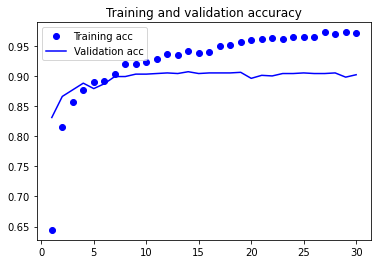

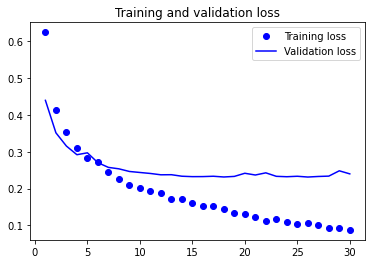

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
#Feature extraction using data augmentation

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 - 132s - loss: 0.5197 - acc: 0.7680 - val_loss: 0.3941 - val_acc: 0.8620
Epoch 2/30
100/100 - 133s - loss: 0.3981 - acc: 0.8315 - val_loss: 0.3260 - val_acc: 0.8790
Epoch 3/30
100/100 - 139s - loss: 0.3578 - acc: 0.8515 - val_loss: 0.2976 - val_acc: 0.8860
Epoch 4/30
100/100 - 135s - loss: 0.3220 - acc: 0.8700 - val_loss: 0.2766 - val_acc: 0.8930
Epoch 5/30
100/100 - 134s - loss: 0.3006 - acc: 0.8760 - val_loss: 0.2742 - val_acc: 0.8890
Epoch 6/30
100/100 - 134s - loss: 0.2862 - acc: 0.8815 - val_loss: 0.2650 - val_acc: 0.8890
Epoch 7/30
100/100 - 133s - loss: 0.2721 - acc: 0.8925 - val_loss: 0.2502 - val_acc: 0.8990
Epoch 8/30
100/100 - 133s - loss: 0.2666 - acc: 0.8880 - val_loss: 0.2498 - val_acc: 0.8900
Epoch 9/30
100/100 - 134s - loss: 0.2572 - acc: 0.9000 - val_loss: 0.2422 - val_acc: 0.8980
Epoch 10/30


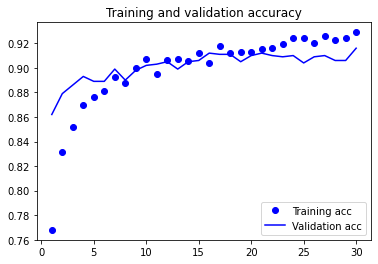

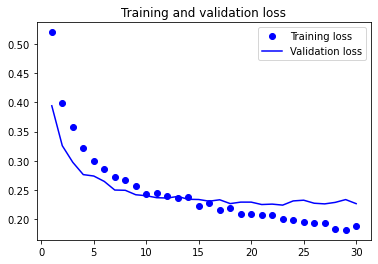

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
#Fine tuning

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 168s 2s/step - loss: 0.2102 - acc: 0.9150 - val_loss: 0.2263 - val_acc: 0.9130
Epoch 2/100
100/100 [==============================] - 179s 2s/step - loss: 0.1662 - acc: 0.9340 - val_loss: 0.2067 - val_acc: 0.9210
Epoch 3/100
100/100 [==============================] - 181s 2s/step - loss: 0.1362 - acc: 0.9470 - val_loss: 0.2107 - val_acc: 0.9200
Epoch 4/100
100/100 [==============================] - 184s 2s/step - loss: 0.1203 - acc: 0.9550 - val_loss: 0.2023 - val_acc: 0.9270
Epoch 5/100
100/100 [==============================] - 186s 2s/step - loss: 0.1085 - acc: 0.9575 - val_loss: 0.2533 - val_acc: 0.8970
Epoch 6/100
100/100 [==============================] - 187s 2s/step - loss: 0.0952 - acc: 0.9620 - val_loss: 0.2365 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 184s 2s/step - loss: 0.0840 - acc: 0.9665 - val_loss: 0.2047 - val_acc: 0.9260
Epoch 8/100
100/100 [==============================] - 188s 2s

Epoch 62/100
100/100 [==============================] - 163s 2s/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.3280 - val_acc: 0.9360
Epoch 63/100
100/100 [==============================] - 163s 2s/step - loss: 0.0034 - acc: 0.9985 - val_loss: 0.3038 - val_acc: 0.9340
Epoch 64/100
100/100 [==============================] - 162s 2s/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.4333 - val_acc: 0.9250
Epoch 65/100
100/100 [==============================] - 161s 2s/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.4026 - val_acc: 0.9240
Epoch 66/100
100/100 [==============================] - 161s 2s/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.4774 - val_acc: 0.9140
Epoch 67/100
100/100 [==============================] - 161s 2s/step - loss: 0.0011 - acc: 0.9995 - val_loss: 0.3640 - val_acc: 0.9280
Epoch 68/100
100/100 [==============================] - 161s 2s/step - loss: 0.0063 - acc: 0.9975 - val_loss: 0.3197 - val_acc: 0.9340
Epoch 69/100
100/100 [==============================] -

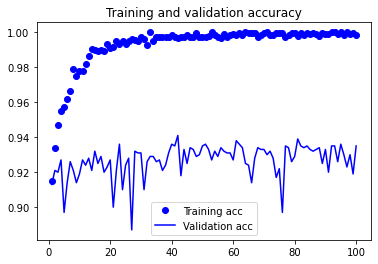

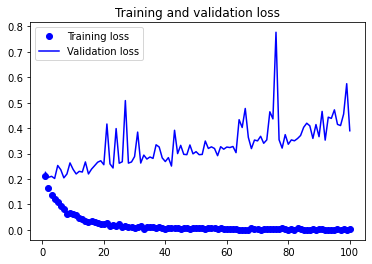

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

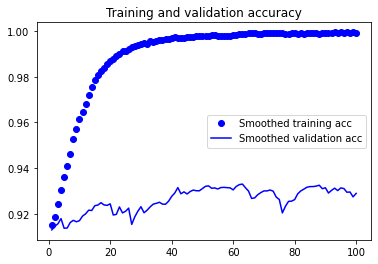

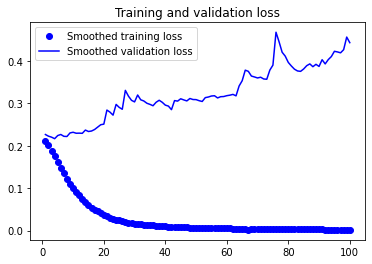

In [24]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9350000023841858
